In [11]:
LEARNING_RATE=0.1
MARGIN = 1.3

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
from sklearn.manifold import TSNE
import random
from itertools import permutations

from keras.optimizers import SGD,Adam
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras import backend as K

In [2]:
(x_train, y_train) , (x_test,y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [3]:
# Define our own plot function
def scatter(x, labels, num_of_labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", num_of_labels))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    # 그래프 규격선, 여백공간 제거
    ax.axis('off') 
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_of_labels):
        # Add Label with txt type on plotting image
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

before shape :  (60000, 28, 28)
after flat shape :  (60000, 784)
before shape :  (10000, 28, 28)
after flat shape :  (10000, 784)
(100, 2)


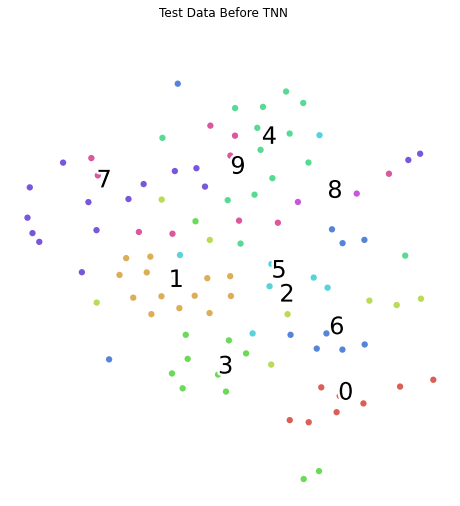

In [4]:
img_row=28
img_column=28
img_channel=1
print("before shape : ",x_train.shape)
x_train_flat = x_train.reshape(-1,img_row*img_column*img_channel)
print("after flat shape : ",x_train_flat.shape)
print("before shape : ",x_test.shape)
x_test_flat = x_test.reshape(-1,img_row*img_column*img_channel)
print("after flat shape : ",x_test_flat.shape)
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(x_test_flat[:100])
print(test_tsne_embeds.shape)
scatter(test_tsne_embeds, y_test[:100], 10, "Test Data Before TNN")

In [5]:
def generate_triplet(x,y,ap_pairs=10,an_pairs=10):
    print("starting generate_triplet_pair")
    print("x shape : ", x.shape,"   y shape : ", y.shape)
    data_xy = tuple([x,y])
    
    triplet_train_pairs = []
    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        print(same_class_idx.shape,diff_class_idx.shape)
        
        # num of each: ap_pairs, an_pairs
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        
        #total data: ap_pairs*an_pairs
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        
        for ap in A_P_pairs:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])
                    
    return np.array(triplet_train_pairs)

In [6]:
def generate_triplet_2(x,y,ap_pairs=10,an_pairs=10):
    print(x.shape, y.shape)
    data_xy = tuple([x,y])
    
    triplet_train_pairs = []
    
    for data_class in sorted(set(data_xy[1])):
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        # num of each: ap_pairs, an_pairs
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        
        #total data: ap_pairs*an_pairs
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        ng_idx=0
        
        for ap in A_P_pairs:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            Negative = data_xy[0][Neg_idx[ng_idx%Neg_len]]
            triplet_train_pairs.append([Anchor,Positive,Negative])
            ng_idx+=1
            
    return np.array(triplet_train_pairs)

In [7]:
x_train_triplet = generate_triplet_2(x_train_flat,y_train,ap_pairs=150,an_pairs=150)
x_test_triplet = generate_triplet_2(x_test_flat,y_test,ap_pairs=150,an_pairs=150)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [8]:
print(x_train_triplet.shape , x_test_triplet.shape)

(1500, 3, 784) (1500, 3, 784)


In [9]:
def create_model():
    #cnn model
    model = Sequential()
    #input shape - mnist.shape 28,28,1
    model.add(Conv2D(128,(7,7),padding='same',input_shape=(28,28,1),activation='relu',name='conv1'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    model.add(Conv2D(256,(10,10),padding='same',activation='relu',name='conv2'))
    model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(4,name='embeddings'))
    return model

In [12]:
def triplet_loss(y_true, y_pred, alpha = MARGIN):
    
    #print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [13]:
#---------------------------------------------------------------------------------------------------
adam_optim = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
#---------------------------------------------------------------------------------------------------
input_row=28
input_column=28
input_channel=1
anchor_input = Input((input_row, input_column, input_channel, ), name='anchor_input')
positive_input = Input((input_row, input_column, input_channel, ), name='positive_input')
negative_input = Input((input_row, input_column, input_channel, ), name='negative_input')

Shared_DNN = create_model()
encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
#---------------------------------------------------------------------------------------------------
model.compile(loss=triplet_loss, optimizer=adam_optim)
model.summary()
#---------------------------------------------------------------------------------------------------
Anchor = x_train_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
Positive = x_train_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
Negative = x_train_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)

Anchor_test = x_test_triplet[:,0,:].reshape(-1,input_row, input_column, input_channel)
Positive_test = x_test_triplet[:,1,:].reshape(-1,input_row, input_column, input_channel)
Negative_test = x_test_triplet[:,2,:].reshape(-1,input_row, input_column, input_channel)


Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

MODEL_SAVE_FOLDER_PATH = './'
LOG_SAVE_FOLDER_PATH = './'
model_path = MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+'-{val_loss:.4f}-{epoch:02d}.hdf5'
log_path = LOG_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+'-log.csv'

csv_logger = CSVLogger(log_path, append=True, separator=';')
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=5)
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
model_history= model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=64, epochs=10, callbacks=[csv_logger,cb_early_stopping,cb_checkpoint])
#---------------------------------------------------------------------------------------------------
model_json = model.to_json()
with open(MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN), "w") as json_file : 
    json_file.write(model_json)

model.save_weights(MODEL_SAVE_FOLDER_PATH + str(LEARNING_RATE+MARGIN)+".h5")
print("Saved model to disk")


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4)            3333636     anchor_input[0][0]               
                                     